# QM Dataset

This is a base class for 'quantum mechanical' datasets. It generates graph properties from a xyz-file, which
stores atomic coordinates.

Additionally, it should be possible to generate approximate chemical bonding information via `OpenBabel`, if this
additional package is installed.
The class inherits from `MemoryGraphDataset`.

At the moment, there is no connection to `MoleculeNetDataset` since usually for geometric data, the usage is
related to learning quantum properties like energy, orbitals or forces and no "chemical" feature information is
required.

For demonstration, we make an artifical table of coordinates and some target values and store them to file.

In [1]:
import os
os.makedirs("ExampleQM", exist_ok=True)
xyz_list = [
    "4\n\nC 0.9949499369 0.0 0.0\nC 2.1952097416 0.0 0.0\nH -0.0707100034 0.0 0.0\nH 3.2608699799 0.0 0.0\n",
    "5\n\nC 0.9982599616 -0.0024599999 -0.0043599997\nH 2.0902099609 -0.0024299999 0.0041399999\nH 0.6337899566 1.0268599987 0.0041399999\nH 0.6270399690 -0.5277299881 0.8781099916\nH 0.6413599849 -0.5074699521 -0.9053999186\n",
    "3\n\nO 0.00000 0.00000 0.11779\nH 0.00000 0.75545 -0.47116\nH 0.00000 -0.75545 -0.47116"
]
xyz_data = "".join(xyz_list)
with open("ExampleQM/qm.xyz", "w") as f:
    f.write(xyz_data)

Or if single files are used

In [2]:
os.makedirs("ExampleQM/XYZ_files", exist_ok=True)
for i, x in enumerate(xyz_list):
    with open("ExampleQM/XYZ_files/mol_%i.xyz" % i, "w") as f:
        f.write(x)
csv_info = "ID,files,energy\n0,mol_0.xyz,-13.0\n1,mol_1.xyz,-20.0\n2,mol_2.xyz,-34.0"
with open("ExampleQM/qm.csv", "w") as f:
    f.write(csv_info)

The file structure is:


```bash
├── ExampleQM
    ├── qm.csv
    ├── XYZ_files  # Need a qm.csv if singe files are used.
    │   ├── *.*
    │   └── ... 
    ├── qm.xyz
    └── qm.sdf  # After prepare_data
```

##  1. Initialization

To load the dataset from memory the `QMDataset` class requires the information of the directory the data is in and the name of the xyz-file. Also required is to provide a name of the dataset. If no single xyz file is available, a csv file of the same base-name must have also a column of files-names in addition to labels.

In [3]:
import numpy as np
from kgcnn.data.qm import QMDataset
dts = QMDataset(
    file_name="qm.xyz",
    file_directory="XYZ_files",
    data_directory="ExampleQM", 
    dataset_name="ExampleQM"
)

## 2. Prepare Data

Prepare Data generates a single XYZ file if it is not available and also tries to maks a mol SDF file from XYZ information via `OpenBabel` if installed.

In [4]:
dts.prepare_data(
    overwrite=True,
    file_column_name="files",  # Delete qm.xyz file to see if it is generated from single files
    make_sdf=True
)

INFO:kgcnn.data.ExampleQM:Converting xyz to mol information.


<QMDataset []>

## 3. Read Data

The information from XYZ file and optinally also form SDF and CSV files are read from disk.

In [5]:
dts.read_in_memory(
    label_column_name="energy"
)

INFO:kgcnn.data.ExampleQM:Reading structures from SDF file.
[16:20:51] Warning: molecule is tagged as 3D, but all Z coords are zero
INFO:kgcnn.data.ExampleQM: ... process molecules 0 from 3


<QMDataset [{'node_symbol': array(['C', 'C', 'H', 'H'], dtype='<U1'), 'node_number': array([6, 6, 1, 1]), 'node_coordinates': array([[ 0.9949,  0.    ,  0.    ],
       [ 2.1952,  0.    ,  0.    ],
       [-0.0707,  0.    ,  0.    ],
       [ 3.2609,  0.    ,  0.    ]]), 'edge_indices': array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 3],
       [2, 0],
       [3, 1]], dtype=int64), 'edge_number': array([3, 1, 3, 1, 1, 1]), 'graph_labels': array(-13.)} ...]>

## 4. Check dataset and graphs

With openbabel QMDataset has both geometric and apporximate bond information.

In [6]:
dts.obtain_property("node_coordinates")

[array([[ 0.9949,  0.    ,  0.    ],
        [ 2.1952,  0.    ,  0.    ],
        [-0.0707,  0.    ,  0.    ],
        [ 3.2609,  0.    ,  0.    ]]),
 array([[ 0.9983, -0.0025, -0.0044],
        [ 2.0902, -0.0024,  0.0041],
        [ 0.6338,  1.0269,  0.0041],
        [ 0.627 , -0.5277,  0.8781],
        [ 0.6414, -0.5075, -0.9054]]),
 array([[ 0.    ,  0.    ,  0.1178],
        [ 0.    ,  0.7554, -0.4712],
        [ 0.    , -0.7554, -0.4712]])]

The graph then must be constructed with edges based on pairwise distances:

In [7]:
dts.map_list("set_range", 
    max_distance=2,
    max_neighbours=15,
    do_invert_distance=False, 
    self_loops=False, 
    exclusive=True
)

<QMDataset [{'node_symbol': array(['C', 'C', 'H', 'H'], dtype='<U1'), 'node_number': array([6, 6, 1, 1]), 'node_coordinates': array([[ 0.9949,  0.    ,  0.    ],
       [ 2.1952,  0.    ,  0.    ],
       [-0.0707,  0.    ,  0.    ],
       [ 3.2609,  0.    ,  0.    ]]), 'edge_indices': array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 3],
       [2, 0],
       [3, 1]], dtype=int64), 'edge_number': array([3, 1, 3, 1, 1, 1]), 'graph_labels': array(-13.), 'range_indices': array([[0, 1],
       [0, 2],
       [1, 0],
       [1, 3],
       [2, 0],
       [3, 1]]), 'range_attributes': array([[1.2003],
       [1.0656],
       [1.2003],
       [1.0657],
       [1.0656],
       [1.0657]])} ...]>

In [8]:
dts.obtain_property("range_attributes")

[array([[1.2003],
        [1.0656],
        [1.2003],
        [1.0657],
        [1.0656],
        [1.0657]]),
 array([[1.09193309],
        [1.09206083],
        [1.09201876],
        [1.09279623],
        [1.09193309],
        [1.78341231],
        [1.78347143],
        [1.78363048],
        [1.09206083],
        [1.78341231],
        [1.78345266],
        [1.7837128 ],
        [1.09201876],
        [1.78347143],
        [1.78345266],
        [1.78367252],
        [1.09279623],
        [1.78363048],
        [1.7837128 ],
        [1.78367252]]),
 array([[0.95788839],
        [0.95788839],
        [0.95788839],
        [1.5108    ],
        [0.95788839],
        [1.5108    ]])]

In [9]:
dts.obtain_property("range_indices")

[array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [2, 0],
        [3, 1]]),
 array([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [1, 2],
        [1, 3],
        [1, 4],
        [2, 0],
        [2, 1],
        [2, 3],
        [2, 4],
        [3, 0],
        [3, 1],
        [3, 2],
        [3, 4],
        [4, 0],
        [4, 1],
        [4, 2],
        [4, 3]]),
 array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 2],
        [2, 0],
        [2, 1]])]

If openbabel is available, the also bond information are given.

In [10]:
dts.obtain_property("edge_indices")

[array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [2, 0],
        [3, 1]], dtype=int64),
 array([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0]], dtype=int64),
 array([[0, 1],
        [0, 2],
        [1, 0],
        [2, 0]], dtype=int64)]

In [11]:
dts.obtain_property("edge_number")

[array([3, 1, 3, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1])]

In [12]:
# We can also clean the dataset to ensure there are no un-connected graphs or empty arrays.
dts.clean(inputs=["edge_number", "edge_indices"])

INFO:kgcnn.data.ExampleQM:No invalid graphs for assigned properties found.


array([], dtype=int32)

Cleaned dataset without empty or zero-length nodes/edges

In [13]:
dts.obtain_property("edge_indices")

[array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [2, 0],
        [3, 1]], dtype=int64),
 array([[0, 1],
        [0, 2],
        [0, 3],
        [0, 4],
        [1, 0],
        [2, 0],
        [3, 0],
        [4, 0]], dtype=int64),
 array([[0, 1],
        [0, 2],
        [1, 0],
        [2, 0]], dtype=int64)]

In [14]:
dts[0]

{'node_symbol': array(['C', 'C', 'H', 'H'], dtype='<U1'),
 'node_number': array([6, 6, 1, 1]),
 'node_coordinates': array([[ 0.9949,  0.    ,  0.    ],
        [ 2.1952,  0.    ,  0.    ],
        [-0.0707,  0.    ,  0.    ],
        [ 3.2609,  0.    ,  0.    ]]),
 'edge_indices': array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [2, 0],
        [3, 1]], dtype=int64),
 'edge_number': array([3, 1, 3, 1, 1, 1]),
 'graph_labels': array(-13.),
 'range_indices': array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 3],
        [2, 0],
        [3, 1]]),
 'range_attributes': array([[1.2003],
        [1.0656],
        [1.2003],
        [1.0657],
        [1.0656],
        [1.0657]])}

## 5. Extensive scaler

For extensive targets like energies, it can be helpful to remove an energy offset which is like a sum of atomization energies. 

In [15]:
from kgcnn.data.transform.scaler.molecule import ExtensiveMolecularScaler

In [16]:
scaler = ExtensiveMolecularScaler()
energies_scaled = scaler.fit_transform(X=dts.obtain_property("graph_labels"), atomic_number=dts.obtain_property("node_number"))
energies_scaled

array([-0.5309174 ,  0.94275059, -1.48855294])

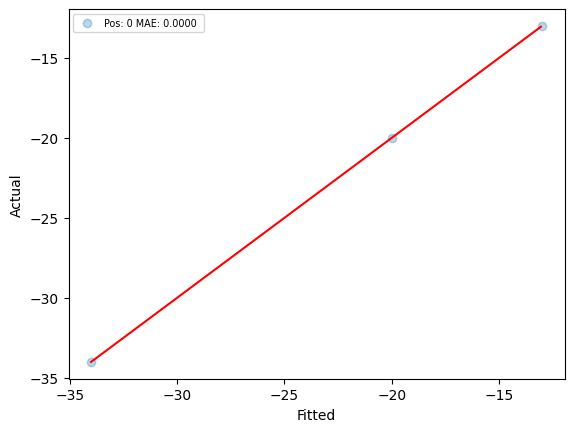

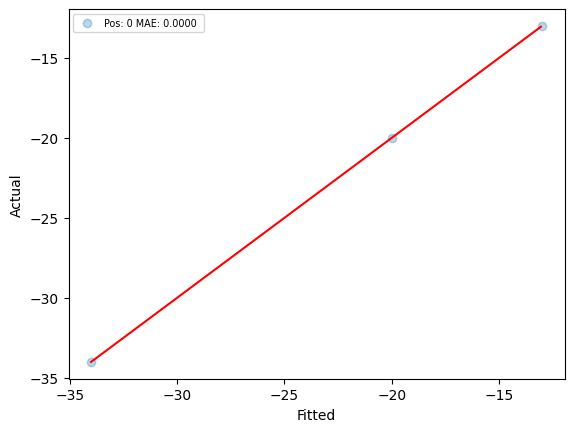

In [17]:
scaler._plot_predict(dts.obtain_property("graph_labels"), dts.obtain_property("node_number"))